## Basic Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

## Cleaning

In [34]:
csv_file_path = 'clean_merged_playerdata_with_weather.csv'

df = pd.read_csv(csv_file_path)

# drop columns we definitely don't need
df = df.drop(["bet_type", "tie_rule", "open_time", "close_time", 
              "p1_outcome_text", "p2_outcome_text", "p3_outcome_text", 
              "book", "event_completed", "event_name", "odds", 
             
             'p1_player_name', 'p2_player_name', 'p3_player_name',
             
             'dg_id_p1', 'fin_text_p1', 'fin_text_p2', 'fin_text_p3',
             'course_name_p1', 'teetime_p2', 'teetime_p3', 'wx_teetime',
             'wx_datetime_hour',
             'wx_date_from_close', 'wx_conditions', 'wx_icon', 'wx_datetimeEpoch',
             'tour_p1', 'season'], axis=1)

# rename columns we'd like to keep
df = df.rename(columns={'teetime_p1':'teetime'})

df = df.drop(["teetime"], axis=1)


# preciptype can either only be nan or 'rain'
df['wx_preciptype'] = df['wx_preciptype'].fillna(0)
df['wx_preciptype'] = df['wx_preciptype'].apply(lambda x: 1 if x != 0 else x)
    

# dropping round scores
df = df.drop(["round_score_p1"], axis=1)
df = df.drop(["round_score_p2"], axis=1)
df = df.drop(["round_score_p3"], axis=1)
    

# Create one outcome column
df['outcome'] = (
    df[['p1_outcome', 'p2_outcome', 'p3_outcome']]
    .fillna(0) # turn all na's or NaNs to 0
    .idxmax(axis=1) 
    .str.extract(r'p(\d+)_outcome') # pull out 1, 2, 3
    .astype(float) # convert to floats
)
# Then remove the other outcome column
df = df.drop(['p1_outcome', 'p2_outcome', 'p3_outcome'], axis=1)


C:\Users\Olive\AppData\Local\Temp\ipykernel_31560\752576875.py:3: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


In [35]:
# create a csv to check changes
df.to_csv('cleaned_golf.csv', index=False)

## PCA

42884
[[  5.22019414   4.82662051   3.4928187  ...  -0.68591565   0.99603745
    0.58479182]
 [  4.69621175   4.55004699  -4.1959368  ...  -0.39763197  -1.62609577
    2.46028087]
 [  4.7160314    3.50080001   4.65961769 ...  -0.65183617   0.87395486
    2.34218427]
 ...
 [-12.42083988   0.62568452  -0.24652952 ...   0.84206525  -3.12998256
   -1.11665534]
 [-12.38742466   0.59965069  -0.37640147 ...   1.12160473  -3.29036705
   -1.38574022]
 [-12.38713784   0.59942722  -0.37751625 ...   1.12400421  -3.29174374
   -1.38804996]]


ValueError: x and y must be the same size

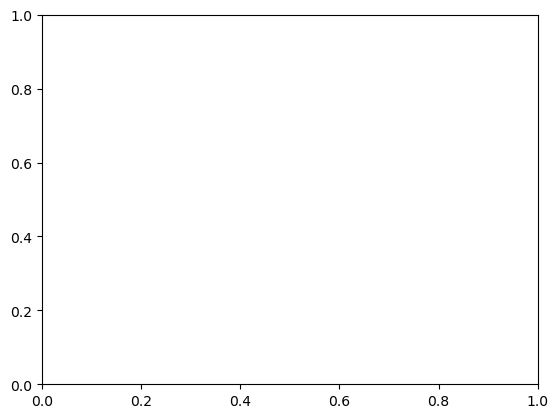

In [44]:
df_copy = df.copy()
df_copy = df_copy.drop(["outcome"], axis=1)

pd.set_option("display.max_columns", None)

df_copy = df_copy.select_dtypes(include=['number'])
df_copy = df_copy.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_copy)

pca = PCA(n_components=10)
transformed_data = pca.fit_transform(X_scaled)

cols = len(transformed_data)

print(cols)

print(transformed_data[:,:cols-1])

plt.scatter(transformed_data[:,:cols-1], transformed_data[:,cols-1:cols], c=df["outcome"], cmap="tab10")
plt.show()

print("Var: ", pca.explained_variance_ratio_)

In [ ]:
def hypothesis(X, theta):
    h =  1 / (1 + (np.exp(-np.dot(X, theta))))
    return h

theta = np.zeros((transformed_data.shape[1], 1))
h = hypothesis(transformed_data, theta)
print (h.shape) # this should be (100, 1)
print (h[0])

def calcLogRegressionCost(X, Y, theta):
    """
    Calculate Logistic Regression Cost

    X: Features matrix
    Y: Output matrix
    theta: matrix of variable weights
    output: return the cost value.
    """

    h = hypothesis(X, theta)

    cost = (np.dot(-Y.T, np.log(h)) - np.dot((1 - Y).T, np.log(1 - h))) / len(X)

    return cost


def logRegressionGradientDescent(X, Y, theta, eta, iters):
    """
    Performs gradient descent optimization on a set of data

    X: Features matrix
    Y: Output matrix
    theta: matrix of variable weights
    eta: learning rate
    iters: number of times to iterate the algorithm (epochs)
    output: return optimized theta and the cost array for each iteration (epoch).
    """
    cost = np.zeros(iters)

    for i in range(iters):
      gradients = 2 * np.dot(X.T, hypothesis(X, theta) - Y) / len(X)
      theta = theta - eta * gradients
      cost[i] = calcLogRegressionCost(X, Y, theta)

    return theta, cost


eta = 0.1
iters = 10000
theta, cost = logRegressionGradientDescent(transformed_data, transformed_data[:, 1], theta, eta, iters)
print(calcLogRegressionCost(transformed_data, transformed_data[:, 1], theta))
print(theta)

## Correlation Matrix

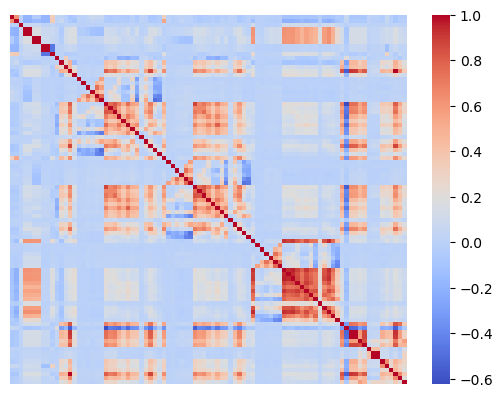

In [37]:
cor = df_copy.corr()
import seaborn as sns

sns.heatmap(cor, xticklabels=False, yticklabels=False, cmap='coolwarm')
plt.show()

## Train Test Split - Preliminary Accuracy of RandomForestClassifier

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df, df['outcome'], test_size=0.25, random_state=0)

print("Training x:", x_train.shape,"y:", y_train.shape)
print("Testing x:", x_test.shape,"y:", y_test.shape)


# This takes ~20 sec to run because there's so much data.
RandomForestClassifier().fit(x_train, y_train).score(x_test, y_test)

Training x: (32163, 93) y: (32163,)
Testing x: (10721, 93) y: (10721,)


0.9995336255946273

## Finding Scores For n_estimators

0.9917918104654416
0.9965488294002425
0.9990672511892548
0.9993470758324783
0.9995336255946273
0.9995336255946273
0.9995336255946273
0.9996269004757019
0.9997201753567764
0.9996269004757019
0.9994403507135529
0.9997201753567764
0.9997201753567764
0.9997201753567764
0.9997201753567764
0.999813450237851
0.9997201753567764
0.999813450237851
0.9997201753567764


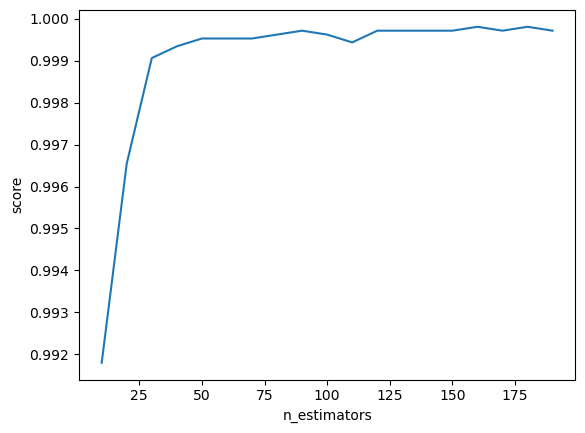

In [ ]:
# This takes forever (like 7 min?) -> don't run it
# Prob adjust to use PCA data if we want to try graphing our scores like this
scores = []
for i in range(10, 200, 10):
    score_i = RandomForestClassifier(n_estimators=i).fit(x_train, y_train).score(x_test, y_test)
    print(score_i)
    scores.append(score_i)
plt.plot(range(10, 200, 10), scores)
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.show()